In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

In [4]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [5]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [6]:
llm.invoke("hiii").content

'Hello! 👋 How can I help you today? 😊\n'

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=150, chunk_overlap=30
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)

retriever = vectorstore.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [8]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.",
)

tools = [retriever_tool]

##### look into the retreiver grader

In [9]:
from pydantic import BaseModel, Field

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

In [10]:
# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeDocuments)

In [11]:
from langchain_core.prompts import ChatPromptTemplate
# Prompt
system = """You are a grader checking if a document is relevant to a user’s question.The check has to be done very strictly..  
If the document has words or meanings related to the question, mark it as relevant.  
Give a simple 'yes' or 'no' answer to show if the document is relevant or not."""
    
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

In [12]:
grade_prompt

ChatPromptTemplate(input_variables=['document', 'question'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template="You are a grader checking if a document is relevant to a user’s question.The check has to be done very strictly..  \nIf the document has words or meanings related to the question, mark it as relevant.  \nGive a simple 'yes' or 'no' answer to show if the document is relevant or not."), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['document', 'question'], input_types={}, partial_variables={}, template='Retrieved document: \n\n {document} \n\n User question: {question}'), additional_kwargs={})])

In [13]:
my_retrieval_grader = grade_prompt | structured_llm_grader
question = "what is ai agent?"

In [14]:

docs = retriever.get_relevant_documents(question)

docs

/tmp/ipykernel_8667/3287265562.py:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)


[Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utiliz

In [15]:
doc_txt = docs[3].page_content

In [16]:
doc_txt

'Given the user request and the call command, the AI assistant helps the user to select a suitable model from a list of models to process the user request. The AI assistant merely outputs the model id of the most appropriate model. The output must be in a strict JSON format: "id": "id", "reason": "your detail reason for the choice". We have a list of models for you to choose from {{ Candidate Models }}. Please select one model from the list.\n\n(3) Task execution: Expert models execute on the specific tasks and log results.\nInstruction:'

In [17]:
print(my_retrieval_grader.invoke({"document":doc_txt,"question": question}))

binary_score='yes'


In [18]:
question1="who is pavan manikanta?"

In [19]:
print(my_retrieval_grader.invoke({"document":doc_txt,"question": question1}))

binary_score='no'


#### Look into the data generation

In [20]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

prompt = hub.pull("rlm/rag-prompt")

In [21]:
prompt.pretty_print()

================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [22]:
rag_chain = prompt | llm

In [23]:
question="what is a AI agent?"

In [24]:
# Testing
generation = rag_chain.invoke({"context": docs, "question": question})

In [25]:
generation.content

'An AI agent is a system with an LLM as its core, capable of planning, remembering, and using tools to accomplish complex tasks.  \nIt breaks down large tasks into smaller steps, learns from its experiences, and can access external information and tools to complete its goals. \n'

- Hallucination Grader

In [26]:
# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

In [27]:
# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

In [28]:
# Prompt
system = """You are a grader checking if an LLM generation is grounded in or supported by a set of retrieved facts.  
Give a simple 'yes' or 'no' answer. 'Yes' means the generation is grounded in or supported by a set of retrieved the facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

In [29]:
hallucinations_grader = hallucination_prompt | structured_llm_grader

In [30]:
print(hallucinations_grader.invoke({"documents": docs, "generation": generation}))

binary_score='yes'


 #### Answer Grader

In [31]:
### Answer Grader
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
print(answer_grader.invoke({"question": question, "generation": generation}))

binary_score='yes'


- Question Re- Writer

In [32]:
system = """You are a question re-writer that converts an input question into a better optimized version for vector store retrieval document.  
You are given both a question and a document.  
- First, check if the question is relevant to the document by identifying a connection or relevance between them.  
- If there is a little relevancy, rewrite the question based on the semantic intent of the question and the context of the document.  
- If no relevance is found, simply return this single word "question not relevant." dont return the entire phrase 
Your goal is to ensure the rewritten question aligns well with the document for better retrieval."""
     
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human","""Here is the initial question: \n\n {question} \n,
             Here is the document: \n\n {documents} \n ,
             Formulate an improved question. if possible other return 'question not relevant'."""
        ),
    ]
)
question_rewriter = re_write_prompt | llm | StrOutputParser()


In [33]:
question="who is a current indian prime minister?"

In [34]:
question_rewriter.invoke({"question":question,"documents":docs})

'question not relevant \n'

In [35]:
from typing import List
from typing_extensions import TypedDict
class AgentState(TypedDict):
    question: str
    generation: str
    documents: List[str]
    filter_documents: List[str]
    unfilter_documents: List[str]

In [36]:
def retrieve(state:AgentState):
    print("----RETRIEVE----")
    question=state['question']
    documents=retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}

In [37]:
def grade_documents(state:AgentState):
    print("----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----")
    question = state['question']
    documents = state['documents']
    
    filtered_docs = []
    unfiltered_docs = []
    for doc in documents:
        score=my_retrieval_grader.invoke({"question":question, "document":doc})
        grade=score.binary_score
        
        if grade=='yes':
            print("----GRADE: DOCUMENT RELEVANT----")
            filtered_docs.append(doc)
        else:
            print("----GRADE: DOCUMENT NOT RELEVANT----")
            unfiltered_docs.append(doc)
    if len(unfiltered_docs)>1:
        return {"unfilter_documents": unfiltered_docs,"filter_documents":[], "question": question}
    else:
        return {"filter_documents": filtered_docs,"unfilter_documents":[],"question": question}
            
            

In [38]:
def decide_to_generate(state:AgentState):
    print("----ACCESS GRADED DOCUMENTS----")
    state["question"]
    unfiltered_documents = state["unfilter_documents"]
    filtered_documents = state["filter_documents"]
    
    
    if unfiltered_documents:
        print("----ALL THE DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY----")
        return "transform_query"
    if filtered_documents:
        print("----DECISION: GENERATE----")
        return "generate"

In [39]:
def generate(state:AgentState):
    print("----GENERATE----")
    question=state["question"]
    documents=state["documents"]
    
    generation = rag_chain.invoke({"context": documents,"question":question})
    return {"documents":documents,"question":question,"generation":generation}

In [40]:
def transform_query(state:AgentState):
    question=state["question"]
    documents=state["documents"]
    
    print(f"this is my document{documents}")
    response = question_rewriter.invoke({"question":question,"documents":documents})
    print(f"----RESPONSE---- {response}")
    if response == 'question not relevant':
        print("----QUESTION IS NOT AT ALL RELEVANT----")
        return {"documents":documents,"question":response,"generation":"question was not at all relevant"}
    else:   
        return {"documents":documents,"question":response}

In [42]:
def decide_to_generate_after_transformation(state:AgentState):
    question=state["question"]
    
    if question=="question not relevant":
        return "query_not_at_all_relevant"
    else:
        return "Retriever"

In [44]:
import pprint
def grade_generation_vs_documents_and_question(state:AgentState):
    print("---CHECK HELLUCINATIONS---")
    question= state['question']
    documents = state['documents']
    generation = state["generation"]
    
    score = hallucinations_grader.invoke({"documents":documents,"generation":generation})
    
    grade = score.binary_score
    
    #Check hallucinations
    if grade=='yes':
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        
        print("---GRADE GENERATION vs QUESTION ---")
        
        score = answer_grader.invoke({"question":question,"generation":generation})
        
        grade = score.binary_score
        
        if grade=='yes':
            print("---DECISION: GENERATION ADDRESS THE QUESTION ---")
            return "useful"
        else:
            print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---TRANSFORM QUERY")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---TRANSFORM QUERY")
        "not useful"
    

_ From here the langgraph workflow will start

In [45]:
from typing import List
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(AgentState)
workflow.add_node("Docs_Vector_Retrieve", retrieve)
workflow.add_node("Grading_Generated_Documents", grade_documents) 
workflow.add_node("Content_Generator", generate)
workflow.add_node("Transform_User_Query", transform_query)

In [46]:
workflow.add_edge(START,"Docs_Vector_Retrieve")
workflow.add_edge("Docs_Vector_Retrieve","Grading_Generated_Documents")
workflow.add_conditional_edges("Grading_Generated_Documents",
                            decide_to_generate,
                            {
                            "generate": "Content_Generator",
                            "transform_query": "Transform_User_Query"
                            }
                            )
workflow.add_conditional_edges("Content_Generator",
                            grade_generation_vs_documents_and_question,
                            {
                            "useful": END,
                            "not useful": "Transform_User_Query",
                            }
                            )
workflow.add_conditional_edges("Transform_User_Query",
                decide_to_generate_after_transformation,
                {
                "Retriever":"Docs_Vector_Retrieve",
                "query_not_at_all_relevant":END
                }
                )

In [47]:
app=workflow.compile()

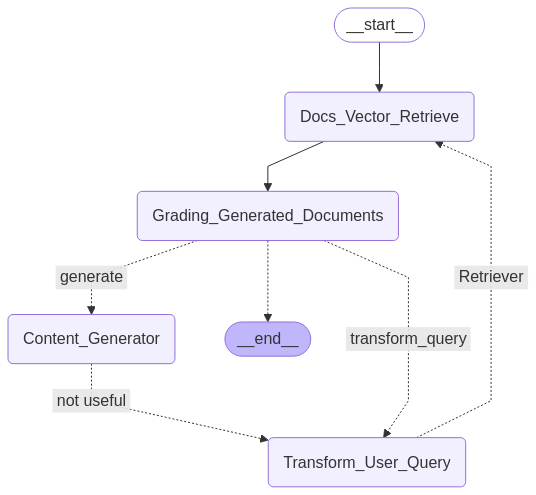

In [48]:
from IPython.display import Image, display # type: ignore
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [49]:
inputs = {"question": "Explain how the different types of agent memory work?"}

In [50]:
app.invoke(inputs)["generation"]

----RETRIEVE----
----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----ACCESS GRADED DOCUMENTS----
----DECISION: GENERATE----
----GENERATE----
---CHECK HELLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION ---
---DECISION: GENERATION ADDRESS THE QUESTION ---


AIMessage(content='Short-term memory in LLMs is akin to in-context learning, using the current prompt and previous interactions to inform its responses.  Long-term memory, on the other hand, relies on external storage like vector databases to retain and recall vast amounts of information over extended periods. \n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 2254, 'total_tokens': 2315, 'completion_time': 0.110909091, 'prompt_time': 0.096816336, 'queue_time': 0.24773157299999998, 'total_time': 0.207725427}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-c7147548-78bb-47a2-aa8b-a98b503b1c92-0', usage_metadata={'input_tokens': 2254, 'output_tokens': 61, 'total_tokens': 2315})

In [51]:
inputs = {"question": "who is a prompt engineering?"}

In [52]:
app.invoke(inputs)["generation"]

----RETRIEVE----
----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----ACCESS GRADED DOCUMENTS----
----DECISION: GENERATE----
----GENERATE----
---CHECK HELLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION ---
---DECISION: GENERATION ADDRESS THE QUESTION ---


AIMessage(content="Prompt engineering is the art of designing effective prompts for language models to elicit desired responses. \nIt involves carefully crafting input text to guide the model's behavior and achieve specific outcomes. \nPrompt engineers experiment with different prompt structures and examples to optimize model performance. \n\n\n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 1467, 'total_tokens': 1524, 'completion_time': 0.103636364, 'prompt_time': 0.051237637, 'queue_time': 0.24495297300000002, 'total_time': 0.154874001}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-9cd0d7b8-ca2b-4cde-9e0a-83529eae88b5-0', usage_metadata={'input_tokens': 1467, 'output_tokens': 57, 'total_tokens': 1524})

In [53]:
inputs = {"question": "what is role of c language and php while creating ai agentic pattern?"}

In [54]:
app.invoke(inputs)["generation"]

----RETRIEVE----
----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT NOT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----ACCESS GRADED DOCUMENTS----
----DECISION: GENERATE----
----GENERATE----
---CHECK HELLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION ---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---TRANSFORM QUERY
this is my document[Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by sev

AIMessage(content="LLM-powered autonomous agents utilize external APIs to access real-time information, proprietary data sources, and execute code. This capability extends the agent's functionality beyond its pre-trained knowledge, enabling it to perform complex tasks requiring external resources. \n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 53, 'prompt_tokens': 2447, 'total_tokens': 2500, 'completion_time': 0.096363636, 'prompt_time': 0.210476898, 'queue_time': 0.255522672, 'total_time': 0.306840534}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-584b6512-8168-45b0-82fe-8e93b221a028-0', usage_metadata={'input_tokens': 2447, 'output_tokens': 53, 'total_tokens': 2500})

In [55]:
inputs = {"question": "what is role of data structure while creating ai agentic pattern?"}

In [56]:
app.invoke(inputs)["generation"]

----RETRIEVE----
----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----ACCESS GRADED DOCUMENTS----
----DECISION: GENERATE----
----GENERATE----
---CHECK HELLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION ---
---DECISION: GENERATION ADDRESS THE QUESTION ---


AIMessage(content='Data structures are crucial for organizing and storing the information an AI agent needs to function.  \n\nThey help the agent manage its memory, plan tasks, and access external tools efficiently. \n\nWithout proper data structures, an AI agent would struggle to perform complex tasks and learn from its experiences. \n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 2201, 'total_tokens': 2263, 'completion_time': 0.112727273, 'prompt_time': 0.07621566, 'queue_time': 0.25085525, 'total_time': 0.188942933}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-151cd809-66b8-414a-ac0f-1623dd1db7a9-0', usage_metadata={'input_tokens': 2201, 'output_tokens': 62, 'total_tokens': 2263})